In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pywt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from math import log10, sqrt
import pandas as pd

In [2]:
_IMG_PATH = '../images/lena512.bmp'

In [3]:
img = cv2.imread(_IMG_PATH)
img.shape

(512, 512, 3)

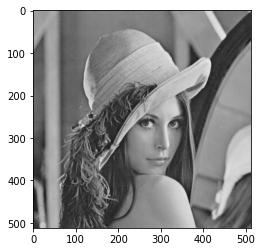

In [4]:
plt.imshow(img)

In [5]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray

array([[162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       ...,
       [ 43,  43,  50, ..., 104, 100,  98],
       [ 44,  44,  55, ..., 104, 105, 108],
       [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8)

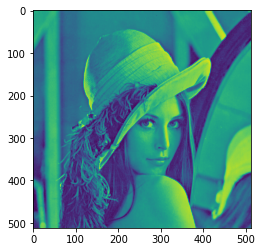

In [6]:
plt.imshow(img_gray)

In [7]:
def add_noisy(img, var=None):
    """
    create a noise array with the same size as the input image
    add noise array into the input image
    """
    row,col= img.shape
    mean = 0
    if not var:
        var = 25
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = img + gauss
    return noisy, gauss

In [8]:
25**0.5

5.0

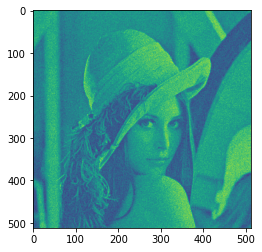

In [9]:
img_noise, noise = add_noisy(img_gray, var=25**2)
plt.imshow(img_noise)

In [10]:
img_noise

array([[170.4938141 , 160.61869925, 105.99966849, ..., 158.39329255,
        167.96180784, 126.8964391 ],
       [184.46880421, 172.88066022, 186.82308917, ..., 145.07442154,
        145.14021341, 133.3859768 ],
       [151.41419398, 153.98592724, 167.70172465, ..., 181.25891711,
        190.43538545, 119.4924392 ],
       ...,
       [ 26.8422268 ,  43.87523731,  47.72061005, ...,  88.61819853,
         80.98586777, 110.2324093 ],
       [ 48.3329576 ,  11.32521476,  51.17522875, ..., 104.34131311,
        122.88436203, 143.21919168],
       [ 42.38437879,  53.91817687,  59.39191015, ..., 106.64584113,
        120.72242026, 143.72316467]])

C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

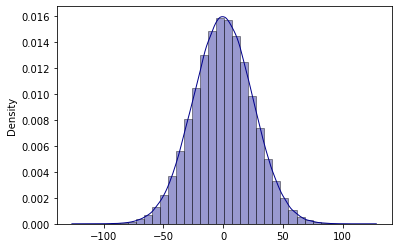

In [11]:
sns.distplot(noise.flatten(), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

In [12]:
def transform_wavelet(spatial):
    coeffs2 = pywt.dwt2(spatial, 'db2')
    return coeffs2

In [13]:
y_coeffs = transform_wavelet(img_noise)
x_coeffs = transform_wavelet(img_gray)
v_coeffs = transform_wavelet(noise)

In [14]:
def variance_est(coeff,var_noise_est):
    var_y = np.var(coeff)
    var_x = np.maximum(var_y-var_noise_est,0)
#     print(var_x)
    tb = var_noise_est/np.sqrt(var_x)
    return tb

In [15]:
# sns.distplot(y_coeffs[0].flatten(), hist=True, kde=True, 
#              bins=int(180/5), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 1})

In [16]:
# sns.distplot(y_coeffs[-1][0].flatten(), hist=True, kde=True, 
#              bins=int(180/5), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 1})

In [17]:
# np.max(x_coeffs[-1][1])

In [18]:
def adaptive_threshold(coeffs, var_noise_est):
    ll, (lh, hl, hh) = coeffs
    
    tb_ll = variance_est(ll, var_noise_est)
    tb_lh = variance_est(lh, var_noise_est)
    tb_hl = variance_est(hl, var_noise_est)
    tb_hh = variance_est(hh, var_noise_est)
    
    thres = (tb_ll, tb_lh, tb_hl, tb_hh)
    return thres

In [19]:
var_noise_est = np.median(np.abs(y_coeffs[-1][-1]))/0.6745
var_noise_est

24.965486691032044

In [20]:
thres = adaptive_threshold(y_coeffs, var_noise_est)

In [21]:
thres

(0.2545085517540066, 0.9971181981914762, 0.970539053497468, 1.0174917678132522)

In [22]:
def soft_thresholding(coeff, thres):
    coeff_thres = np.zeros((coeff.shape[0],coeff.shape[1]))
    for i in range(coeff.shape[0]):
        for j in range(coeff.shape[1]):
            sgn = coeff[i][j]/np.abs(coeff[i][j])
            thres_func = np.maximum((np.abs(coeff[i][j]) - thres), 0)
            coeff_thres[i][j] = sgn*thres_func
    return coeff_thres

In [23]:
def denoising_by_threshold(coeffs_origin, coeffs_w_noise, thres):
    ll, (lh, hl, hh) = coeffs_w_noise
    tb_ll, tb_lh, tb_hl, tb_hh = thres
    
#     ll_w_thres = soft_thresholding(ll, tb_ll)
    lh_w_thres = soft_thresholding(lh, tb_lh)
    hl_w_thres = soft_thresholding(hl, tb_hl)
    hh_w_thres = soft_thresholding(hh, tb_hh)
    
    ll_origin, (lh_origin, hl_origin, hh_origin) = coeffs_origin
    
    coeff_w_thres = ll, (lh_w_thres, hl_w_thres, hh_w_thres)
    
#     mse_ll = mean_squared_error(ll_origin, ll_w_thres)
    mse_lh = mean_squared_error(lh_origin, lh_w_thres)
    mse_hl = mean_squared_error(hl_origin, hl_w_thres)
    mse_hh = mean_squared_error(hh_origin, hh_w_thres)
    
    mse_sum = mse_lh + mse_hl + mse_hh
    
    return mse_sum, coeff_w_thres

## Context variable

In [24]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def padding_coeffs(coeffs):
    ll, (lh, hl, hh) = coeffs
    ll_pad = np.pad(ll, 1, pad_with)
    lh_pad = np.pad(lh, 1, pad_with)
    hl_pad = np.pad(hl, 1, pad_with)
    hh_pad = np.pad(hh, 1, pad_with)
    
    coeffs_pad = ll_pad, (lh_pad, hl_pad, hh_pad)
    return coeffs_pad

def moving_window_reshape(coeffs, shape = (3,3)):
    ll, (lh, hl, hh) = coeffs
    ll_mvwd = np.lib.stride_tricks.sliding_window_view(ll, shape)
    lh_mvwd = np.lib.stride_tricks.sliding_window_view(lh, shape)
    hl_mvwd = np.lib.stride_tricks.sliding_window_view(hl, shape)
    hh_mvwd = np.lib.stride_tricks.sliding_window_view(hh, shape)
    
    ll_mvwd_rs = np.abs(np.reshape(ll_mvwd,(ll_mvwd.shape[0]*ll_mvwd.shape[1],ll_mvwd.shape[2]*ll_mvwd.shape[3])))
    lh_mvwd_rs = np.abs(np.reshape(lh_mvwd,(lh_mvwd.shape[0]*lh_mvwd.shape[1],lh_mvwd.shape[2]*lh_mvwd.shape[3])))
    hl_mvwd_rs = np.abs(np.reshape(hl_mvwd,(hl_mvwd.shape[0]*hl_mvwd.shape[1],hl_mvwd.shape[2]*hl_mvwd.shape[3])))
    hh_mvwd_rs = np.abs(np.reshape(hh_mvwd,(hh_mvwd.shape[0]*hh_mvwd.shape[1],hh_mvwd.shape[2]*hh_mvwd.shape[3])))
    
    coeffs_mvwd_rs = ll_mvwd_rs, (lh_mvwd_rs, hl_mvwd_rs, hh_mvwd_rs)
    return coeffs_mvwd_rs

In [25]:
y_coeffs_padding = padding_coeffs(y_coeffs)
y_coeffs_mvwd_rs = moving_window_reshape(y_coeffs_padding)

### Weight average least squares estimate

In [26]:
def tb_est(context_fall, var_noise_est):
    """
    context_fall is an array 3x3
    """
    var_y = np.var(context_fall)
    var_x = np.maximum(var_y-var_noise_est,0)

    tb = var_noise_est/np.sqrt(var_x)
    
    return tb

def location_threshold(coeffs_mvwd_rs, var_noise_est):
    
    ll_mvwd_rs, (lh_mvwd_rs, hl_mvwd_rs, hh_mvwd_rs) = coeffs_mvwd_rs
    
    return contexts

### Survey context fall

In [27]:
def lse(u, y):
    ut_mul_u = np.matmul(u.T,u)
    inv = np.linalg.inv(ut_mul_u)
    inv_mul_ut = np.matmul(inv,u.T)
    return np.matmul(inv_mul_ut,np.abs(y))

def context_z(neighbors, weight):
    context = np.zeros(neighbors.shape[0])
    
    for i in range(neighbors.shape[0]):
        ele = np.reshape(neighbors[i],(neighbors[i].shape[0],1))
        z = np.matmul(weight.T,ele)
        context[i] = z
    context_rs = np.reshape(context,(int(np.sqrt(neighbors.shape[0])),int(np.sqrt(neighbors.shape[0]))))
    return context_rs
        

def weight_avg_lse(coeffs, coeffs_mvwd_rs):
    ll, (lh, hl, hh) = coeffs
    
    ll_rs = np.reshape(ll, (ll.shape[0]*ll.shape[1],1))
    lh_rs = np.reshape(lh, (lh.shape[0]*lh.shape[1],1))
    hl_rs = np.reshape(hl, (hl.shape[0]*hl.shape[1],1))
    hh_rs = np.reshape(hh, (hh.shape[0]*hh.shape[1],1))

    ll_mvwd_rs, (lh_mvwd_rs, hl_mvwd_rs, hh_mvwd_rs) = coeffs_mvwd_rs
    
    w_ll = lse(ll_mvwd_rs, ll_rs)
    w_lh = lse(lh_mvwd_rs, lh_rs)
    w_hl = lse(hl_mvwd_rs, hl_rs)
    w_hh = lse(hh_mvwd_rs, hh_rs)
    
#     w_coeffs = w_ll, (w_lh, w_hl, w_hh)
    
    ll_context = context_z(ll_mvwd_rs, w_ll)
    lh_context = context_z(lh_mvwd_rs, w_lh)
    hl_context = context_z(hl_mvwd_rs, w_hl)
    hh_context = context_z(hh_mvwd_rs, w_hh)
    
    contexts = ll_context, (lh_context, hl_context, hh_context)
    
    return contexts

In [28]:
ll_context, (lh_context, hl_context, hh_context) = weight_avg_lse(y_coeffs, y_coeffs_mvwd_rs)

C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


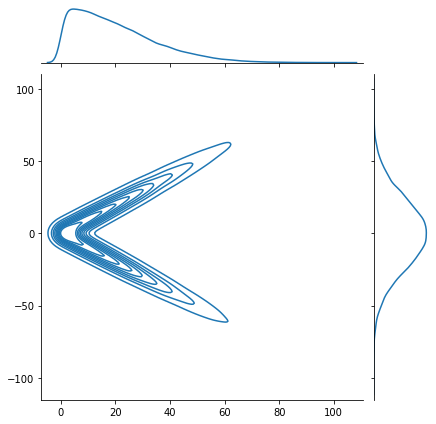

In [46]:
sns.jointplot(hh_context.flatten(), y_coeffs[1][-1].flatten(), kind="kde")

C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

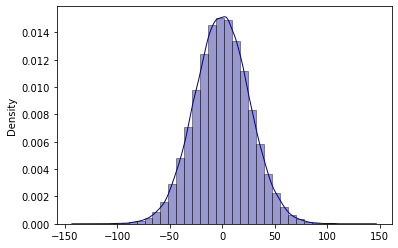

In [31]:
sns.distplot( y_coeffs[1][1].flatten(), 
             hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

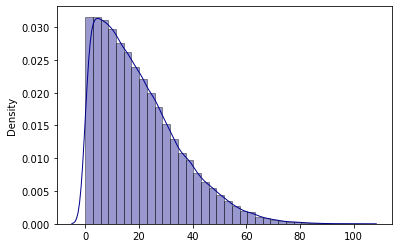

In [32]:
sns.distplot(hh_context.flatten(), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

In [33]:
def denoise_multi_process(args):
    coeffs_origin, coeffs_w_noise, thres = args
    mse,_ = denoising_by_threshold(coeffs_origin, coeffs_w_noise, thres)
    return mse

In [34]:
mse, coeff_w_thres = denoising_by_threshold(x_coeffs, y_coeffs, thres)

In [35]:
mse

1748.8315455717413

C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

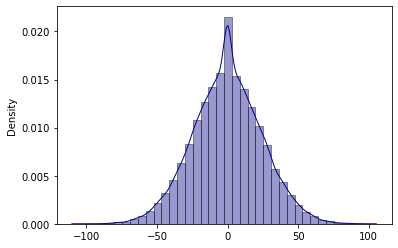

In [36]:
sns.distplot(coeff_w_thres[-1][-1].flatten(), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

In [37]:
img_denoise = pywt.waverec2(coeff_w_thres, 'db2')

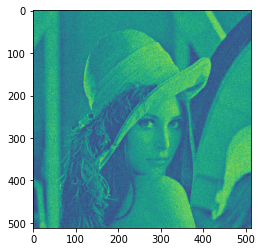

In [38]:
plt.imshow(img_denoise)

In [39]:
def PSNR(img_origin, img_denoise):
    mse = np.mean((img_origin - img_denoise) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [40]:
PSNR(img_gray, img_noise),PSNR(img_gray, img_denoise)

(20.184142411518927, 20.385867904385215)